# Feature Engineering¶

 According to wikipedia, Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering is a tedious precess and often relies on domain expertise. Since i have limited domain knowledge of loans and what makes a person likely to default, i will instead concentrate of getting as much info as possible into the final training dataframe. The idea is that the model will then pick up on which features are important rather than us having to decide that. Here, we will look at using information from the bureau and bureau_balance data . 
Reference : https://www.kaggle.com/c/home-credit-default-risk


## Count of a client's previous loan

groupby : A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups. In our case, we we will group by the unique client, the SK_ID_CURR column

agg : Aggregate using one or more operations over the specified axis.. 

merge : match the arregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the SK_ID_CURR column which will insert NaN in any cell for which the client does not have the corresponding statistic

 We use the rename  function to specify the columns to be renamed as a dictionary. 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
# Read in bureau
bureau = pd.read_csv(r'C:\Users\user\bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# Groupby the client id(SK_ID_CURR), count the number of previous loans, and rename the column
loanprevious = bureau.groupby(['SK_ID_CURR'], as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'loanprevious'})
loanprevious.head()

,SK_ID_CURR,loanprevious
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [5]:
# Join to the training dataframe
train = pd.read_csv(r'C:\Users\user\application_train.csv')
train = train.merge(loanprevious, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0
train['loanprevious'] = train['loanprevious'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,loanprevious
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can see the new column at the right

## Determine usefulness of the new variable through kernel density plot
A Density Plot visualises the distribution of data over a continuous interval or time period. The peaks of a Density Plot help display where values are concentrated over the interval. An advantage Density Plots have over Histograms is that they're better at determining the distribution shape because they're not affected by the number of bins used. We will show the kernel density estimate of the loanprevious colored by whether the TARGET==1 or 0. This will be an indication of the relevance of the variable.


In [6]:
# Plots the distribution of a varaible colored by value of the target
def target(var, dfname):
    # Calculate the correlation coefficient between the new variable and the target
    corr = dfname['TARGET'].corr(dfname[var])

    # Calculate medians for repaid vs not repaid
    avg_repaid = dfname.loc[dfname['TARGET']==0, var].median()
    avg_not_repaid = dfname.loc[dfname['TARGET'], var].median()

    plt.figure(figsize=(12, 6))

    # Plot the distribution for target == 0 and target ==1
    sns.kdeplot(dfname.loc[dfname['TARGET']==0, var], label = 'TARGET ==0')
    sns.kdeplot(dfname.loc[dfname['TARGET']==1, var], label = 'TARGET ==1')

    # label the plot
    plt.xlabel(var);plt.ylabel('Density');plt.title('%s Distribution'% var)
    plt.legend();

    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f'% (var, corr))
    print('Median value for loan that was not repaid = %0.4f'% avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f'% avg_repaid)

We will test this function using the EXT_SOURCE_3 variable

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.1394
Median value for loan that was repaid = 0.5460


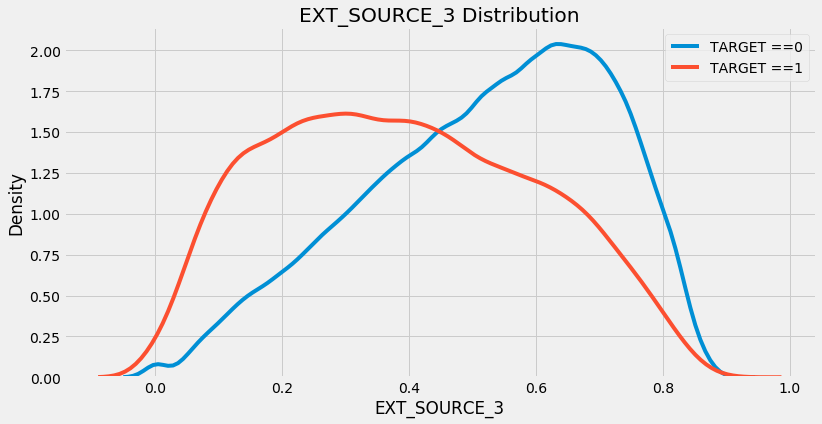

In [7]:
target('EXT_SOURCE_3', train)

Now, we can have the number of previous loans at other institutions.

The correlation between loanprevious and the TARGET is -0.0100
Median value for loan that was not repaid = 8.0000
Median value for loan that was repaid = 4.0000


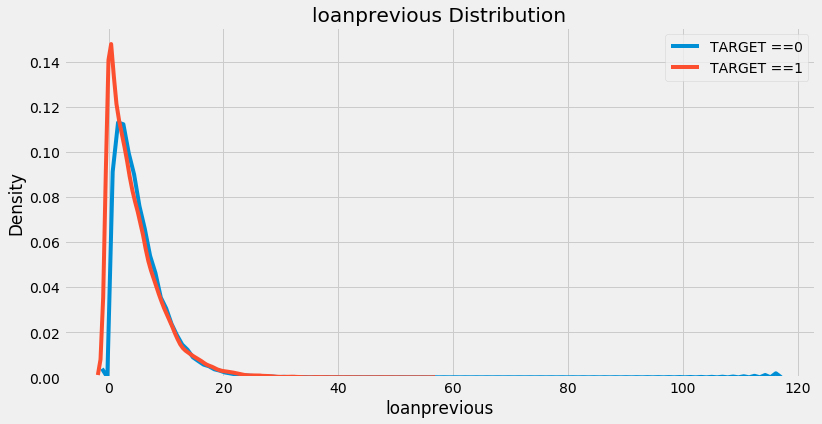

In [8]:
target('loanprevious', train)

### There is almost no difference in the distribution. So it is difficult to tell if this variable will be important. We will make a few more variables from the bureau dataframe.

## Aggregating Numeric Columns
### To do this we can compute statistics for all the numeric columns. To do so, we groupby the client id, agg the grouped dataframe, and merge the result back into the training data.

In [9]:
# Group bu the client id, calculate aggregation statistics
agg_bureau = bureau.drop(columns=['SK_ID_BUREAU']).groupby(['SK_ID_CURR'], as_index = False).agg(
    ['count', 'mean', 'max', 'min', 'sum']
).reset_index()
agg_bureau.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

### We can create new names for each of these columns by appending the stat to the name

In [10]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in agg_bureau.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        # Iterate through the stat names
        for stat in agg_bureau.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s'%(var, stat))

In [11]:
# Assign the list of columns names as the dataframe column names
agg_bureau.columns = columns
agg_bureau.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### merge with the training data

In [12]:
train = train.merge(agg_bureau, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Correlation of Aggregated Values with Target
We can calculate the correlation of all new value with the target by sorting the correlation by the magnitude(absolute value) through the sorted Python function. 

In [13]:
# List of new correlations
corrs = []

# Iterate through the columns
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])

    # Append the list as a tuple
    corrs.append((col, corr))

In [14]:
# Sort the correlations by the absolute value
corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.0897289672199717),
 ('bureau_DAYS_CREDIT_min', 0.0752482510300949),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.0689273526696787),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984394234),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560101363),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.053199625857606535),
 ('bureau_DAYS_CREDIT_max', 0.04978205463996769),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611139944),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433482983),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247072526),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484196),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.041403635353055225),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632504),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161209),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665330753)]

### None of the new variables have a significant correlation with the TARGET. We can look at the KDE plot of the highest correlated variable, bureau_DAYS_CREDIT_mean, with the target in terms of absolute maginitude correlation.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -874.0000
Median value for loan that was repaid = -1067.0000


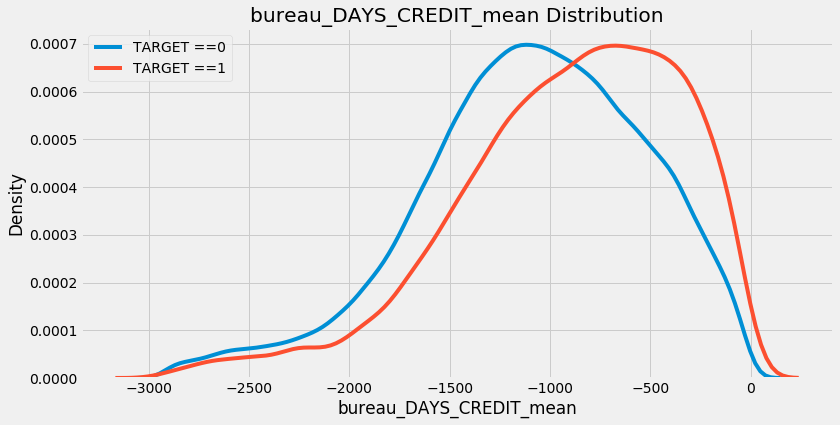

In [15]:
target('bureau_DAYS_CREDIT_mean', train)

### A larger negative number indicates the loan was further before the current loan application. We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit. 

## Function for Numeric Aggregations
### Let's encapsulate all of the previous work into a function. 

In [16]:
def numeric_agg (df, group_v, df_name):
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_v and 'SK_ID' in col:
            df = df.drop(columns = col)

    group_ids = df[group_v]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_v] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_v).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_v]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variables
        if var != group_v:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s'%(df_name, var, stat))

    agg.columns = columns
    return agg

In [17]:
agg_new_bureau = numeric_agg(bureau, group_v = 'SK_ID_CURR', df_name = 'bureau')
agg_new_bureau .head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### comparison  with the aggregated dataframe 

In [18]:
agg_bureau.shape

(305811, 61)

### code to calculate correlations with the target

In [19]:
# Function to calculate correlations with the target for a dataframe
def target(df):

    # List of correlations
    corrs = []

    # Iterate through the columns
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the tareget
            corr = df['TARGET'].corr(df[col])

            
            # Append the list as a tuple
            corrs.append((col, corr))

    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x : abs(x[1]), reverse = True)

    return corrs

## Categorical Variables
### We will rely on calculating value counts of each category within each categorical variable. We will encode the categorical variables to capture the information they contain.

In [20]:
# one-hot encode a dataframe with only the categorical columns (dtype == 'object')
categorical_columns = pd.get_dummies(bureau.select_dtypes('object'))
categorical_columns['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical_columns.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [21]:
categorical_gr = categorical_columns.groupby(['SK_ID_CURR']).agg(['sum', 'mean'])
categorical_gr.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

### The sum columns represent the count of that category for the associated client and the mean represents the normalized count. We can use a similar function as before to rename the columns.

In [22]:
categorical_gr.columns.levels[0]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan',
       'CREDIT_TYPE_Unknown type of loan'],
      dtype='object')

In [23]:
categorical_gr.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [24]:
group_v = 'SK_ID_CURR'

# Need to create new column namese
columns = []

# Iterate through the variables names
for v in categorical_gr.columns.levels[0]:
    # Skip the grouping variables
    if v != group_v:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s'%(var, stat))

# Rename the columns
categorical_gr.columns = columns

categorical_gr.head()

,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,...,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### The sum column records the count and the mean column records the normalized count.
### We can merge this dataframe into the training data.

In [25]:
train = train.merge(categorical_gr, left_on='SK_ID_CURR',
                    right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
train.shape

(307511, 229)

In [27]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm,SK_ID_CURR_count,SK_ID_CURR_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Function to Handle Categorical Variables

In [28]:
def categorical_c(df, group_v, df_name):
    
    # Select the categorical columns
    categorical_columns = pd.get_dummies(df.select_dtypes('object'))

    # put the identifying id on the column
    categorical_columns[group_v] = df[group_v]

    # Groupby the group var and calculate the sum and mean
    categorical_columns =  categorical_columns.groupby(group_v).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in  categorical_columns.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical_columns.columns = column_names
    
    return  categorical_columns

In [29]:
counts_bureau = categorical_c(bureau, group_v='SK_ID_CURR',
                                  df_name = 'bureau')
counts_bureau.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Applying Operations to another dataset
We will now turn to the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial instituions. We will first gorup the dataframe by the SK_ID_BUREAU which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the SK_ID_CURR and calculate the aggregations across the loans of each client. 

In [32]:
# Read in bureau balance
bureau_balance = pd.read_csv(r'C:\Users\user\bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [36]:
# Counts of each type of status for each previous loan 
bureau_balance_counts = categorical_c(bureau_balance, group_v = 'SK_ID_BUREAU',
                                          df_name = 'bureau_balacne')
bureau_balance_counts.head()

,bureau_balacne_STATUS_0_count,bureau_balacne_STATUS_0_count_norm,bureau_balacne_STATUS_1_count,bureau_balacne_STATUS_1_count_norm,bureau_balacne_STATUS_2_count,bureau_balacne_STATUS_2_count_norm,bureau_balacne_STATUS_3_count,bureau_balacne_STATUS_3_count_norm,bureau_balacne_STATUS_4_count,bureau_balacne_STATUS_4_count_norm,bureau_balacne_STATUS_5_count,bureau_balacne_STATUS_5_count_norm,bureau_balacne_STATUS_C_count,bureau_balacne_STATUS_C_count_norm,bureau_balacne_STATUS_X_count,bureau_balacne_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Now we can handle the one numeric column. The MONTHS_BALANCE column has the "months of balance relative to application data." 

In [37]:
#value count statistics for each 'SK_ID_CURR'
bureau_balance_agg = numeric_agg(bureau_balance, group_v = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


## The above dataframes have the calculations done on each loan. We will aggregate these for each client.

In [38]:
# Dataframe grouped by the loan

bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True,
                                          left_on = "SK_ID_BUREAU", how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU',
                                      how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balacne_STATUS_0_count,bureau_balacne_STATUS_0_count_norm,bureau_balacne_STATUS_1_count,bureau_balacne_STATUS_1_count_norm,...,bureau_balacne_STATUS_3_count_norm,bureau_balacne_STATUS_4_count,bureau_balacne_STATUS_4_count_norm,bureau_balacne_STATUS_5_count,bureau_balacne_STATUS_5_count_norm,bureau_balacne_STATUS_C_count,bureau_balacne_STATUS_C_count_norm,bureau_balacne_STATUS_X_count,bureau_balacne_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [39]:
bureau_balance_by_client = numeric_agg(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),
                                       group_v = 'SK_ID_CURR',
                                       df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balacne_STATUS_X_count_count,client_bureau_balacne_STATUS_X_count_mean,client_bureau_balacne_STATUS_X_count_max,client_bureau_balacne_STATUS_X_count_min,client_bureau_balacne_STATUS_X_count_sum,client_bureau_balacne_STATUS_X_count_norm_count,client_bureau_balacne_STATUS_X_count_norm_mean,client_bureau_balacne_STATUS_X_count_norm_max,client_bureau_balacne_STATUS_X_count_norm_min,client_bureau_balacne_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


the bureau_balance dataframe we:


1.   Calculated numeric stats grouping by each loan
2.   Made value counts of each categorical variable grouping by loan
3.   Merged the stats and the value counts on the loans
4.   Calculated numeric stats and for the resulting dataframe grouping by the client id

Some explanation : 


*   Client_bureau_balance_MONTH_BALANCE_mean_mean : Fore each loan calculate the mean value of MONTHS_BALANCE. Then for each client, calculate the mean of this value for all of their loans.
*  client_bureau_balance_STATUS_X_count_norm_sum : For each loan, calculate the number of occurances of STATUS == X divided by the number of total STATUS values for the loan. Then, for each client, add up the values for each loan. 


## Putting the Functions Together

In [40]:
# Free up memory by deleting old objects
import gc
gc.enable() 
del train, bureau, bureau_balance, agg_bureau, agg_new_bureau, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, counts_bureau
gc.collect() 

8957

In [41]:
# Read in new copies of all the dataframes
train = pd.read_csv(r'C:\Users\user\application_train.csv')
bureau = pd.read_csv(r'C:\Users\user\bureau.csv')
bureau_balance = pd.read_csv(r'C:\Users\user\bureau_balance.csv')

## Counts of Bureau Dataframe

In [42]:
bureau_counts = categorical_c(bureau, group_v = 'SK_ID_CURR',
                                  df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## Aggregated Stats of Bureau Dataframe

In [43]:
bureau_agg = numeric_agg(bureau.drop(columns = ['SK_ID_BUREAU']),
                         group_v = 'SK_ID_CURR',
                         df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


## Value counts of Bureau Balance dataframe by loan

In [45]:
bureau_balance_counts = categorical_c(bureau_balance, group_v = 'SK_ID_BUREAU',
                                          df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


## Aggregated stats of Bureau Balance dataframe by loan

In [46]:
bureau_balance_agg = numeric_agg(bureau_balance, group_v='SK_ID_BUREAU',
                                 df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


## Aggregated Stats of Bureau Balance by client

In [47]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts,
                                          right_index = True,
                                          left_on = 'SK_ID_BUREAU',
                                          how = 'outer')
# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan,
                                                              on = 'SK_ID_BUREAU',
                                                              how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = numeric_agg(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),
                                       group_v = 'SK_ID_CURR',
                                       df_name = 'client')

## Insert Computed Features into Training Data

In [48]:
original_f = list(train.columns)
print('Original Number of Features: ', len(original_f))

Original Number of Features:  122


In [49]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR',
                    how = 'left')
# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR',
                    how = 'left')

In [50]:
new_f = list(train.columns)
print('Number of features using previous loans from other institutions data: ',
      len(new_f))

Number of features using previous loans from other institutions data:  333


### Feature Engineering Outcomes
We can look at the percentage of missing values, the correlations of variables with the target, and also the correlation of variables with the other variables. The correlations between variables can show if we have collinear variables, that is, variables that are highly correlated with one another. Often, we want to remove one in a pair of collinear variables because having both variables would be redundant. We can also use the percentage of missing values to remove features with a substantial majority of values that are not present. We will use feature selection to reduce the number of feature.

Feature selection is also called variable selection or attribute selection. It is the automatic selection of attributes in your data (such as columns in tabular data) that are most relevant to the predictive modeling problem you are working on.. There are a number of tools we can use for this process, but in this notebook we will sitck to removing columns with a high percentage of missing values and variables that have a high correlation with one another. Later we can look at using the feature importances returned from models such as th Gradient Boosting Machine or Random Forest to perform feature selections.

## Missing Values
An important consideration is the missing values in the dataframe. Columns with too many missing values might have to be dropped

In [51]:
# Function to calculate missing values by column
def missing_values_t(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing value
    mis_val_percent = df.isnull().sum() / train.shape[0]

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)

    # Rename columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0:'Missing Values', 1 : '% of Total Values'}
    )
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
                                mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
                                    '% of Total Values', ascending=False
                                ).round(1)
    
    # Print some summary information
    print('Your selected dataframe has '+ str(df.shape[1]) + " columns. \n"+
                                              'There are '+str(mis_val_table_ren_columns.shape[0]))
    # Return the dataframe with missing informaion
    return mis_val_table_ren_columns

In [52]:
missing_train = missing_values_t(train)
missing_train.head(10)

Your selected dataframe has 333 columns. 
There are 278


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,0.7
bureau_AMT_ANNUITY_max,227502,0.7
bureau_AMT_ANNUITY_mean,227502,0.7
client_bureau_balance_STATUS_0_count_mean,215280,0.7
client_bureau_balance_STATUS_C_count_norm_max,215280,0.7
client_bureau_balance_STATUS_X_count_mean,215280,0.7
client_bureau_balance_MONTHS_BALANCE_sum_mean,215280,0.7
client_bureau_balance_MONTHS_BALANCE_sum_max,215280,0.7
client_bureau_balance_MONTHS_BALANCE_sum_min,215280,0.7
client_bureau_balance_STATUS_C_count_norm_min,215280,0.7


## We see there are a number of columns with a high percentage of missing values.To reduce the number of features, we will remove any columns in either the training or the testing data that have greater than 90% missing valuse

In [53]:
missing_train_v = missing_train.index[missing_train['% of Total Values']>0.9]
len(missing_train_v)

0

## missing value percentages in the testing data

In [54]:
# Read in the test dataframe
test = pd.read_csv(r'C:\Users\user\application_test.csv')

# Merged with the value counts of bureau
test= test.merge(bureau_counts, on = 'SK_ID_CURR',
                  how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR',
                  how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR',
                  how = 'left')

In [55]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


## We need to align the testing and training dataframes, so that they can have the same columns 

In [56]:
train_l = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_l

In [57]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


## The dataframe now have the same columns(with the exception of the TARGET column in the training data). We can use them in a mahine learning model .

### percentage of missing values in the testing data

In [58]:
missing_test = missing_values_t(test)
missing_test.head(10)

Your selected dataframe has 332 columns. 
There are 275


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,0.1
COMMONAREA_AVG,33495,0.1
COMMONAREA_MODE,33495,0.1
NONLIVINGAPARTMENTS_MODE,33347,0.1
NONLIVINGAPARTMENTS_AVG,33347,0.1
NONLIVINGAPARTMENTS_MEDI,33347,0.1
FONDKAPREMONT_MODE,32797,0.1
LIVINGAPARTMENTS_MODE,32780,0.1
LIVINGAPARTMENTS_AVG,32780,0.1
LIVINGAPARTMENTS_MEDI,32780,0.1


In [59]:
missing_test_v = list(missing_test.index[missing_test['% of Total Values']>=0.9])
len(missing_test_v)

0

In [60]:
missing_c = list(set(missing_test_v + missing_train_v))
print('There are %d columns with more than 90%% missing in either the training or testing data. '% len(missing_c))

There are 0 columns with more than 90% missing in either the training or testing data. 


In [61]:
# Drop the missing columns
train = train.drop(columns = missing_c)
test = test.drop(columns=missing_c)

## We ended up removing no columns becaouse there are no columns with more than 90% missing values. To reduce the dimensionality, we will apply another featuire selection method

In [62]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## Correlations
### We will look at the correlations of the variables with the target.

In [63]:
#  correlations in dataframe
cors = train.corr()

In [65]:
cors = cors.sort_values('TARGET', ascending = False)
# Then most positive correlations
pd.DataFrame(cors['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [66]:
# Ten most negitive correlations
pd.DataFrame(cors['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


## Collinear Variables
We can calculate not only the correlations of the variables with the target, but also the correlations of each variables with every other variable

In [69]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_v = {}

# For each column, record the variables that are above the threshold
for col in cors:
    above_threshold_v[col] = list(cors.index[cors[col]>threshold])

The following code creates a set of variables to remove by only adding one of each pair

In [70]:
above_threshold_v.items()

dict_items([('SK_ID_CURR', ['SK_ID_CURR']), ('CNT_CHILDREN', ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']), ('AMT_INCOME_TOTAL', ['AMT_INCOME_TOTAL']), ('AMT_CREDIT', ['AMT_CREDIT', 'AMT_GOODS_PRICE']), ('AMT_ANNUITY', ['AMT_ANNUITY']), ('AMT_GOODS_PRICE', ['AMT_CREDIT', 'AMT_GOODS_PRICE']), ('REGION_POPULATION_RELATIVE', ['REGION_POPULATION_RELATIVE']), ('DAYS_BIRTH', ['DAYS_BIRTH']), ('DAYS_EMPLOYED', ['DAYS_EMPLOYED']), ('DAYS_REGISTRATION', ['DAYS_REGISTRATION']), ('DAYS_ID_PUBLISH', ['DAYS_ID_PUBLISH']), ('OWN_CAR_AGE', ['OWN_CAR_AGE']), ('FLAG_MOBIL', ['FLAG_MOBIL']), ('FLAG_EMP_PHONE', ['FLAG_EMP_PHONE']), ('FLAG_WORK_PHONE', ['FLAG_WORK_PHONE']), ('FLAG_CONT_MOBILE', ['FLAG_CONT_MOBILE']), ('FLAG_PHONE', ['FLAG_PHONE']), ('FLAG_EMAIL', ['FLAG_EMAIL']), ('CNT_FAM_MEMBERS', ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']), ('REGION_RATING_CLIENT', ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']), ('REGION_RATING_CLIENT_W_CITY', ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']), ('HOUR_

In [71]:

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_v.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))



Number of columns to remove:  133


We can remove these columns from both the training and the testing datasets.

In [72]:
train_cors_removed = train.drop(columns = cols_to_remove)
test_cors_removed = test.drop(columns = cols_to_remove)

print('Training Cors Removed Shape: ', train_cors_removed.shape)
print('Testing Cors Removed Shape: ', test_cors_removed.shape)

Training Cors Removed Shape:  (307511, 200)
Testing Cors Removed Shape:  (48744, 199)


In [73]:
train_cors_removed.to_csv('train_bureau_cors_removed.csv', index = False)
test_cors_removed.to_csv('test_bureau_cors_removed.csv', index = False)

## Modeling
To actually test the performance of these new datasets, we will try using them for machine learning

For all datasets, use the model shown below(with the exact hyperparameters).

control: only the data in the application files

test one : the data in the application files with all of the data recorded from the bureau and bureau_balance files

test two : the data in the application files with all of the data recorded from the bureau and bureau_balance files with highly correlated variables removed.

In [85]:
import lightgbm as lgb
import sklearn.model_selection
sklearn.model_selection.KFold

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [92]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                 # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
      
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [93]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### control
We will use the function defined above (that implements a Gradient Boosting Machine model) and the single main data source(application) to establish a control

In [94]:
train_control = pd.read_csv(r'C:\Users\user\application_train.csv')
test_control = pd.read_csv(r'C:\Users\user\application_test.csv')

The function above returns a submission dataframe, a fi dataframe of feature importances, and a metrics dataframe with validation and test performance.

In [95]:
submission, fi, metrics = model(train_control, test_control, encoding = 'ohe', n_folds = 5)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798402	train's binary_logloss: 0.548246	valid's auc: 0.760094	valid's binary_logloss: 0.561937
Early stopping, best iteration is:
[270]	train's auc: 0.809955	train's binary_logloss: 0.536899	valid's auc: 0.760435	valid's binary_logloss: 0.55484
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798514	train's binary_logloss: 0.548241	valid's auc: 0.761102	valid's binary_logloss: 0.566424
Early stopping, best iteration is:
[223]	train's auc: 0.802473	train's binary_logloss: 0.544332	valid's auc: 0.761328	valid's binary_logloss: 0.564145
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.799641	train's binary_logloss: 0.546889	valid's auc: 0.750166	valid's binary_logloss: 0.564526
Early stopping, best iteration is:
[224]	train's auc: 0.803744	train's binary_logloss: 0.542767

In [96]:
metrics

,fold,train,valid
0,0,0.809955,0.760435
1,1,0.802473,0.761328
2,2,0.803744,0.750327
3,3,0.809674,0.760824
4,4,0.828844,0.761533
5,overall,0.810938,0.758904


### The control overfits because the training score is higher than the validation score. We can visualize the feature importance. It may be useful for feature selection.

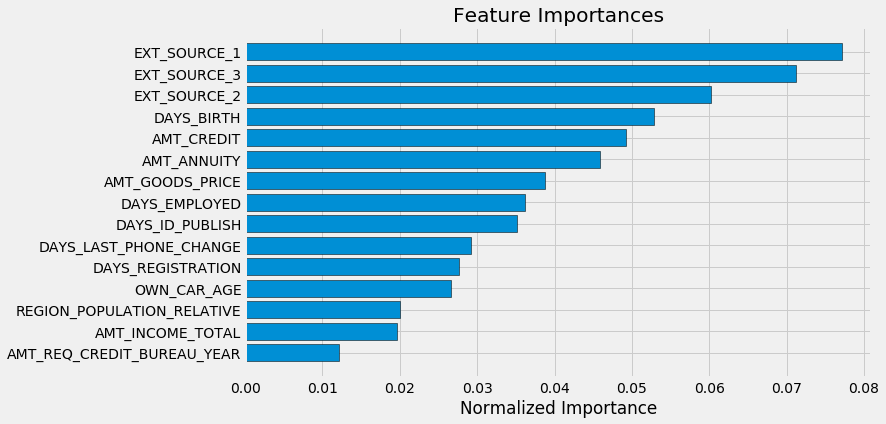

In [97]:
fi_sorted = plot_feature_importances(fi)

In [99]:
submission.to_csv('control.csv', index = False)

## Test One
Let's conduct the first test. 

In [100]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810592	train's binary_logloss: 0.536844	valid's auc: 0.766574	valid's binary_logloss: 0.552573
Early stopping, best iteration is:
[283]	train's auc: 0.825534	train's binary_logloss: 0.521602	valid's auc: 0.767082	valid's binary_logloss: 0.543159
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810124	train's binary_logloss: 0.537204	valid's auc: 0.766665	valid's binary_logloss: 0.557427
Early stopping, best iteration is:
[292]	train's auc: 0.827177	train's binary_logloss: 0.519816	valid's auc: 0.767108	valid's binary_logloss: 0.546829
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.811563	train's binary_logloss: 0.535453	valid's auc: 0.761068	valid's binary_logloss: 0.553559
Early stopping, best iteration is:
[209]	train's auc: 0.813405	train's binary_logloss: 0.53360

In [101]:
metrics_raw

,fold,train,valid
0,0,0.825534,0.767082
1,1,0.827177,0.767108
2,2,0.813405,0.761310
3,3,0.825292,0.768233
4,4,0.814424,0.767608
5,overall,0.821166,0.766259


Based on these numbers, the engineered features perform better than the control case

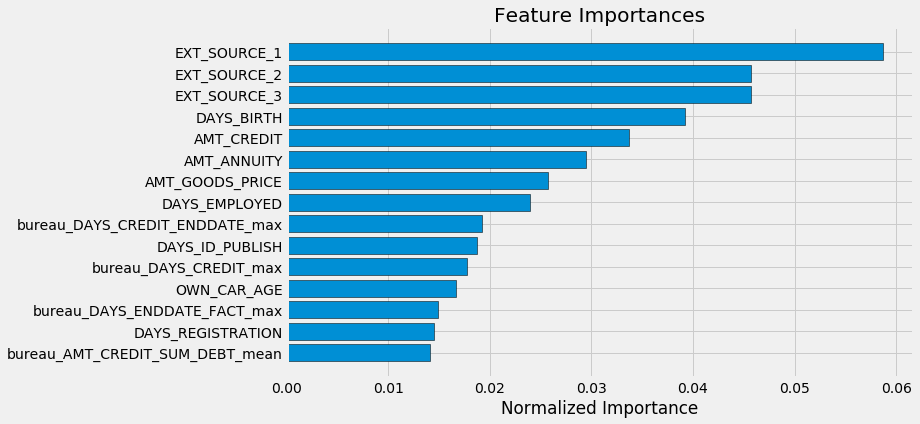

In [102]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [105]:
submission_raw.to_csv('test_one.csv', index = False)

## Test Two
 Same as before but with the highly collinear variables removed.

In [106]:
submission_corrs, fi_corrs, metrics_corr = model(train_cors_removed, test_cors_removed)

Training Data Shape:  (307511, 319)
Testing Data Shape:  (48744, 319)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.805608	train's binary_logloss: 0.541437	valid's auc: 0.763489	valid's binary_logloss: 0.556317
Early stopping, best iteration is:
[295]	train's auc: 0.822492	train's binary_logloss: 0.524597	valid's auc: 0.76431	valid's binary_logloss: 0.545747
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.805747	train's binary_logloss: 0.541673	valid's auc: 0.764733	valid's binary_logloss: 0.560968
Early stopping, best iteration is:
[281]	train's auc: 0.820323	train's binary_logloss: 0.526993	valid's auc: 0.765964	valid's binary_logloss: 0.551653
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807319	train's binary_logloss: 0.539549	valid's auc: 0.756641	valid's binary_logloss: 0.557536
Early stopping, best iteration is:
[272]	train's auc: 0.820183	train's binary_logloss: 0.526615

In [107]:
metrics_corr

,fold,train,valid
0,0,0.822492,0.764310
1,1,0.820323,0.765964
2,2,0.820183,0.757142
3,3,0.817478,0.764711
4,4,0.830872,0.765547
5,overall,0.822269,0.763544


These results are better than the control, but slightly lower than the raw features.

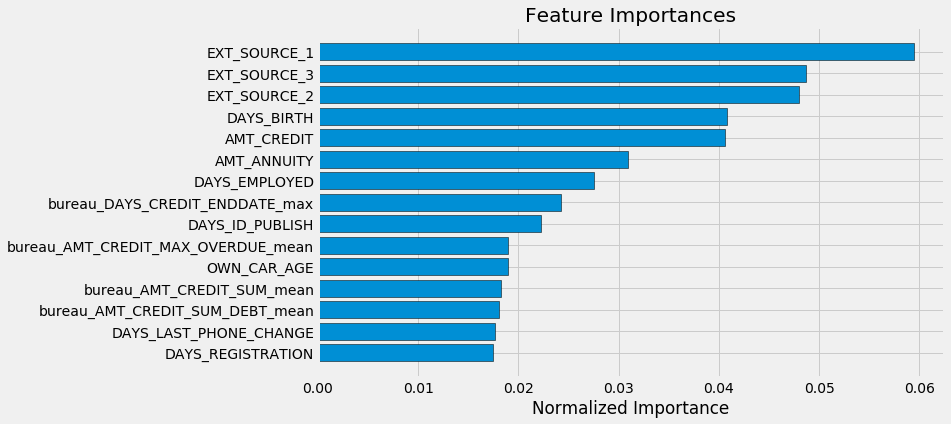

In [108]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [109]:
submission_corrs.to_csv('test_two.csv', index = False)

### Results
All of our hard work translates to a small improvement of 0.014 ROC AUC over the original testing data. Removing the highly collinear variables decreases performance so we will want to consider a different method for feature selection. Moreover, we can say that some of the features we built are among the most important as judged by the model.:




```
Experiment	Train AUC	Validation AUC	        
Control	    0.810	       0.760	           
Test One	0.821	       0.766	            
Test Two	0.822	       0.763	             
```

Going forward, we can use the functions we developed on the other datasets. 